<a href="https://colab.research.google.com/github/AxelCornelly/WGU_CS_Capstone/blob/main/WGU_Computer_Science_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries/dependencies and Obtain Dataset**

The dataset our model will be trained on comes from Kaggle.com. It is a collection of images of handwritten English characters A-Z (Both upper and lower case) and the numbers 0-9. The dataset can be found [here](https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset).

In [ ]:
# @title
# Install kagglehub and ensure it's up to date.
!pip install --upgrade kagglehub
!pip install imgaug

# Import dependencies
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import HTML, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import ipywidgets as widgets
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.ticker as mtick
import imgaug.augmenters as iaa
import imgaug as ia
import kagglehub


# Download/Fetch dataset from Kaggle
datasetPath = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")

100%|██████████| 13.1M/13.1M [00:00<00:00, 179MB/s]

Extracting files...


# **Working with data**

Now that we have imported our dataset, we need to load and process the data so that it can be trained and tested on against our model. Here, we apply augmentations to the dataset images randomly to introduce variablility in our data.

## Transforming the data with sklearn and imgaug

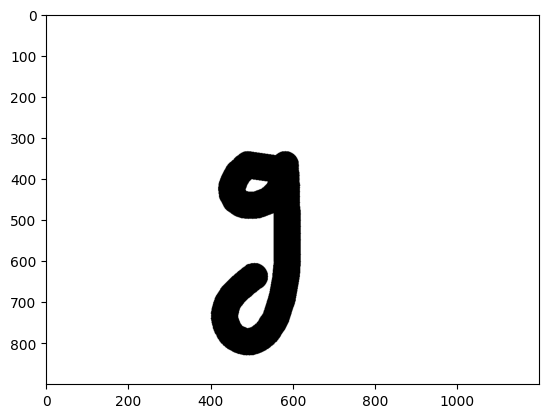

In [ ]:
# @title
# Store data
dataCSVPath = os.path.join(datasetPath, "english.csv")
dataCSV = pd.read_csv(dataCSVPath)
labels = dataCSV["label"].values
imgPaths = dataCSV["image"].values
images = []

# Define augmentations:
# rotate between -25 & 25 degrees
# translate/move image between -20% and 20% on both axes
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25), translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, cval=255)
    ], random_order=True)

# Function to resize character images with respect to aspect ratio
def resizeCharImg(img, targetW=100, targetH=100):
  h, w = img.shape[:2]

  # Calculate aspect ratio
  aspectRatio = w / h

  # Calculate new dimensions
  if aspectRatio > 1:
    newW = targetW
    newH = int(newW / aspectRatio)
  else:
    newH = targetH
    newW = int(newH * aspectRatio)

  # Resize
  if h > targetH and w > targetW: # If image is larger than target dimension, shrink
    resizedImg = cv2.resize(img, (newW, newH), interpolation=cv2.INTER_AREA)
  elif h < targetH and w < targetW: # If image is smaller than target dimension, enlarge
    resizedImg = cv2.resize(img, (newW, newH), interpolation=cv2.INTER_LINEAR)
  else: # Otherwise, assume larger and shrink
    resizedImg = cv2.resize(img, (newW, newH), interpolation=cv2.INTER_AREA)

  # Padding
  padW = (targetW - newW) // 2
  padH = (targetH - newH) // 2
  resizedAndPaddedImg = cv2.copyMakeBorder(resizedImg, padH, padH, padW, padW, cv2.BORDER_CONSTANT, value=255)

  return resizedAndPaddedImg

# Function to load and process images
def loadandProcessImgs(paths):
  for path in paths:
    fullImgPath = os.path.join(datasetPath, path)
    img = cv2.imread(fullImgPath, cv2.IMREAD_GRAYSCALE) # Open in grayscale
    # Check if image was loaded
    if img is not None:
      # Original images are 900x1200, resizing to fit into 100x100
      img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_AREA)

      # Chance to apply random augmentation
      augProbability = 0.25 # 25% chance to apply augmentation
      if np.random.rand() < augProbability:
        augmentedImg = seq(image=img)
        img = augmentedImg

      images.append(img)
    else:
      print(f"Failed to load image from path: {fullImgPath}")
  return np.array(images)

# Load and store the processed images
images = loadandProcessImgs(imgPaths)

# Function to extract HOG features
def extractHOGFeatures(image):
  features, hogImg = hog(image,
                         orientations=9,
                         pixels_per_cell=(6, 6),
                         cells_per_block=(2, 2),
                         visualize=True,
                         block_norm="L2-Hys")

  return features, hogImg

# Apply HOG feature extraction
hogFeatures = []
hogImages = []
for img in images:
  features, hi = extractHOGFeatures(img)
  hogImages.append(hi)
  hogFeatures.append(features)

hogFeatures = np.array(hogFeatures)

# Display some processed images

def displayRandImgs():
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
  for i in range(3):
    randIdx = np.random.randint(0, len(images))
    axes[0, i].imshow(images[randIdx], cmap=plt.cm.gray_r, interpolation="nearest")
    axes[0, i].set_title(f"Label: {labels[randIdx]}")
    axes[1, i].imshow(hogImages[randIdx], cmap="gray")
    axes[1, i].set_title(f"HOG Image of: {labels[randIdx]}")

  plt.tight_layout()
  plt.show()

displayRandImgs()

randIdx = np.random.randint(0,len(imgPaths))
fullPath = os.path.join(datasetPath, imgPaths[randIdx])
randImg = cv2.imread(fullPath)
plt.imshow(randImg)

## Creating the Training and Validation Datasets

xTrain shape: (2728, 8100)
yTrain shape: (2728,)
xTest shape: (682, 8100)
yTest shape: (682,)


Text(0.5, 1.0, 'Original Image')

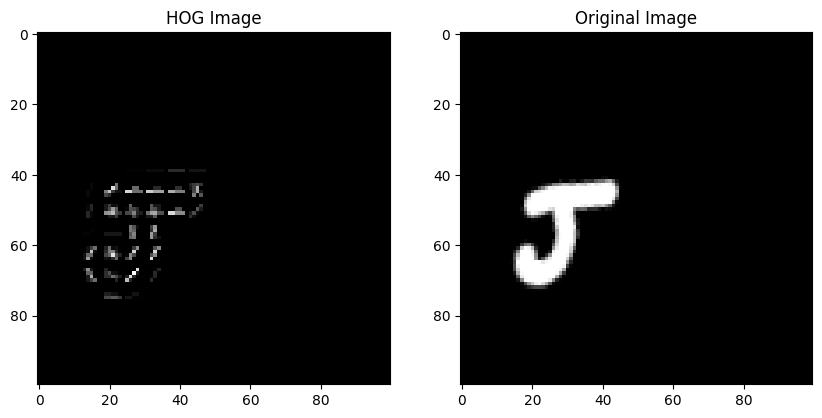

In [ ]:
# Splitting the data into training and validation (testing) sets
xTrain, xTest, yTrain, yTest = train_test_split(hogFeatures,
                                                labels,
                                                test_size=0.2, # 0.2 means 20% of the data will be used for testing
                                                random_state=42)

# Standardize the training data
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)
print("xTrain shape:", xTrain.shape)
print("yTrain shape:", yTrain.shape)
print("xTest shape:", xTest.shape)
print("yTest shape:", yTest.shape)

# Display a random image's features from the training set
randIdx = np.random.randint(0, len(xTrain))
features, randHogImg = extractHOGFeatures(images[randIdx])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(randHogImg, cmap="gray")
axes[0].set_title("HOG Image")
axes[1].imshow(images[randIdx], cmap=plt.cm.gray_r, interpolation="nearest")
axes[1].set_title("Original Image")

# **The Model**

Now that the dataset is prepped, we can create our ML model.

In [ ]:
# 62 classes = 26(A-Z) + 26(a-z) + 10(0-9)

# Creating a starting model using Support Vector Machines (SVM)
# svmModel = SVC(kernel="rbf")
# svmModel.fit(xTrain, yTrain)
# accuracy = svmModel.score(xTest, yTest)
# print("Accuracy:", accuracy)

# Hyperparameter Tuning w/ GridSearch
# from sklearn.model_selection import GridSearchCV
# paramGrid = {
#     "C": [0.1, 1, 10, 100],
#     "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
#     "kernel": ["linear", "rbf"]
# }

# gridSearch = GridSearchCV(svmModel, paramGrid, cv=5, scoring="accuracy")
# gridSearch.fit(xTrain, yTrain)
# print("Best parameters:", gridSearch.best_params_)
# print("Best score:", gridSearch.best_score_)

# Results:
# Best Params: C: 0.1, kernel: linear, gamma: scale
# Best Score: ~43% accuracy

# SVM Model based on above results, adjusted since original model had higher accuracy
svmModel = SVC(kernel="rbf", C=10000)
svmModel.fit(xTrain, yTrain)
accuracy = svmModel.score(xTest, yTest)
print("Accuracy:", accuracy)

Accuracy: 0.4750733137829912


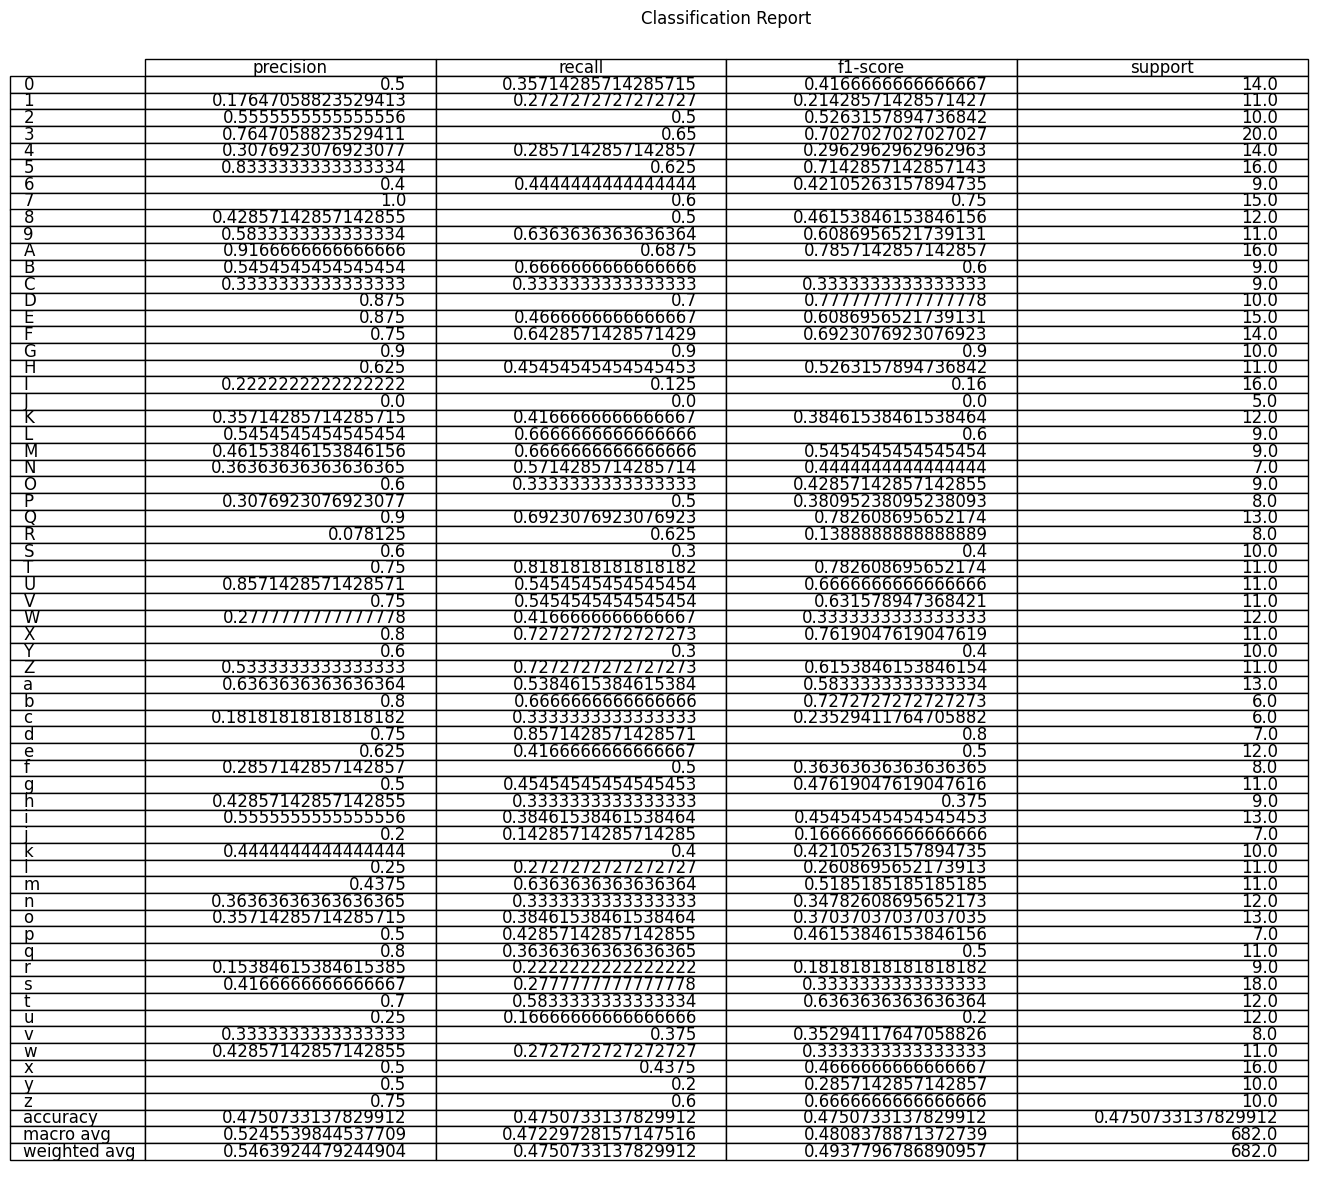

In [ ]:
# Evaluate the model
yPred = svmModel.predict(xTest)

# Classification Report
classificationReport = classification_report(yTest, yPred, output_dict=True)

reportDf = pd.DataFrame(classificationReport).transpose()
fig, axes = plt.subplots(figsize=(15,15))
axes.axis("tight")
axes.axis("off")
table = axes.table(cellText=reportDf.values, colLabels=reportDf.columns, rowLabels=reportDf.index, loc="center")
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.title("Classification Report")
plt.show()

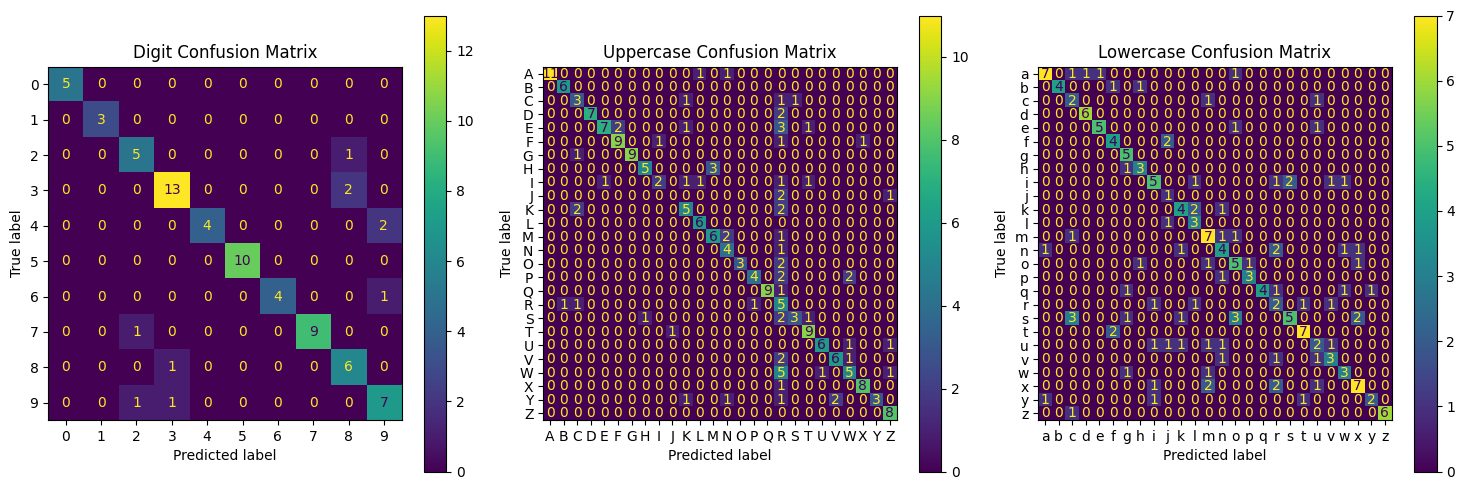

In [ ]:
# Display confusion matrices
digitIdx = []
uppercaseIdx = []
lowercaseIdx = []
for i, label in enumerate(yTest):
  if label.isdigit():
    digitIdx.append(i)
  elif label.isupper():
    uppercaseIdx.append(i)
  else:
    lowercaseIdx.append(i)

yTestDigit = yTest[digitIdx]
yPredDigit = yPred[digitIdx]

yTestUppercase = yTest[uppercaseIdx]
yPredUppercase = yPred[uppercaseIdx]

yTestLowercase = yTest[lowercaseIdx]
yPredLowercase = yPred[lowercaseIdx]

digitsCM = confusion_matrix(yTestDigit, yPredDigit, labels=np.unique(yTestDigit))
uppercaseCM = confusion_matrix(yTestUppercase, yPredUppercase, labels=np.unique(yTestUppercase))
lowercaseCM = confusion_matrix(yTestLowercase, yPredLowercase, labels=np.unique(yTestLowercase))

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
dispDigits = ConfusionMatrixDisplay(confusion_matrix=digitsCM, display_labels=np.unique(yTestDigit))
dispDigits.plot(ax=ax[0])
ax[0].set_title("Digit Confusion Matrix")

dispUppercase = ConfusionMatrixDisplay(confusion_matrix=uppercaseCM, display_labels=np.unique(yTestUppercase))
dispUppercase.plot(ax=ax[1])
ax[1].set_title("Uppercase Confusion Matrix")

dispLowercase = ConfusionMatrixDisplay(confusion_matrix=lowercaseCM, display_labels=np.unique(yTestLowercase))
dispLowercase.plot(ax=ax[2])
ax[2].set_title("Lowercase Confusion Matrix")

plt.tight_layout()
plt.show()

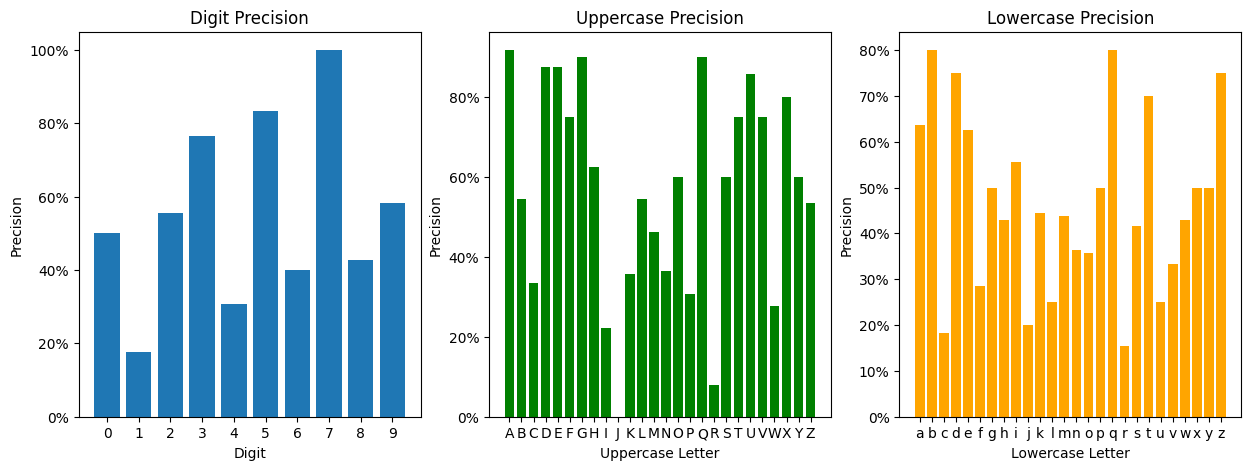

In [ ]:
# More visualizations

# Function to separate labels into 3 groups: Digits, Uppercase, Lowercase
# and return metrics for each
def separateMetrics(metric):
  # Check if input metric is valid, otherwise return None
  validMetrics = ["precision", "recall", "f1-score", "support"]
  if metric not in validMetrics:
    return None

  classLabels = np.unique(yTest)
  digitMetrics = []
  uppercaseMetrics = []
  lowercaseMetrics = []
  for label in classLabels:
    if label.isdigit():
      digitMetrics.append(classificationReport[label][metric])
    elif label.isupper():
      uppercaseMetrics.append(classificationReport[label][metric])
    else:
      lowercaseMetrics.append(classificationReport[label][metric])

  return digitMetrics, uppercaseMetrics, lowercaseMetrics

# Bar chart of the precision of predicting each class
digitPrecision, uppercasePrecision, lowercasePrecision = separateMetrics("precision")

classLabels = np.unique(yTest)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axes[0].bar(range(len(digitPrecision)), digitPrecision)
axes[0].set_title("Digit Precision")
axes[0].set_ylabel("Precision")
axes[0].set_xlabel("Digit")
axes[0].set_xticks(range(len(digitPrecision)))
axes[0].set_xticklabels(classLabels[:len(digitPrecision)])

axes[1].bar(range(len(uppercasePrecision)), uppercasePrecision, color="green")
axes[1].set_title("Uppercase Precision")
axes[1].set_ylabel("Precision")
axes[1].set_xlabel("Uppercase Letter")
axes[1].set_xticks(range(len(uppercasePrecision)))
axes[1].set_xticklabels(classLabels[len(digitPrecision):len(digitPrecision)+len(uppercasePrecision)])

axes[2].bar(range(len(lowercasePrecision)), lowercasePrecision, color="orange")
axes[2].set_title("Lowercase Precision")
axes[2].set_ylabel("Precision")
axes[2].set_xlabel("Lowercase Letter")
axes[2].set_xticks(range(len(lowercasePrecision)))
axes[2].set_xticklabels(classLabels[len(digitPrecision)+len(uppercasePrecision):])

for ax in axes:
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


# **Using The Model**

Now that the model has been created and trained, we get to interact with it! Running the code below will create an interactive canvas where you will be able to draw your own English character or number. Once finished, click the "Submit" button to have the model predict what you drew.

Source code for the canvas comes from [this github gist](https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca).

In [ ]:
# Credit to Github user korakot for this source code for the canvas
# https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Submit</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillStyle = "white"
ctx.fillRect(0, 0, canvas.width, canvas.height)
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='userInput.png', w=500, h=300, line_width=3):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

draw()

# Function for character segmentation
def segmentCharacters(img):

  # Apply adaptive thresholding
  threshImg = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

  # Find connected components
  numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(threshImg, connectivity=8)

  # List of character images and bounding boxes
  charImgs = []
  boxes = []

  for i in range(1, numLabels):
    # Extract bounding box
    x, y, w, h, area = stats[i]

    # Extra padding for bounding box
    padding = 8
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(img.shape[1] - x, w + 2 * padding)
    h = min(img.shape[0] - y, h + 2 * padding)

    # Store bounding box
    boxes.append((x, y, w, h))

    # Extract character
    charImg = img[y:y+h, x:x+w]

    # Append to list
    charImgs.append(charImg)

  # Resize each segment
  resizedChars = []
  for char in charImgs:
    resizedImg = resizeCharImg(char)
    resizedChars.append(resizedImg)

  # Sort from left-to-right
  sortedImgs = []
  for box, char in sorted(zip(boxes, resizedChars)):
    sortedImgs.append(char)

  return sortedImgs

userImg = cv2.imread("userInput.png", cv2.IMREAD_GRAYSCALE)
userChars = segmentCharacters(userImg)

# Apply model to each character
res = ""
hogImgs = []
for charImg in userChars:
  features, hogImg = extractHOGFeatures(charImg)
  hogImgs.append(hogImg)
  features = features.reshape(1, -1)
  # Check for num features, resize if necessary
  # if features.shape[1] != scaler.n_features_in_:
  #   features = np.resize(features, (1, scaler.n_features_in_))

  features = scaler.transform(features)
  prediction = svmModel.predict(features)[0]
  res += prediction

print("Prediction:", res)

Prediction: RZIIO


Num characters: 5


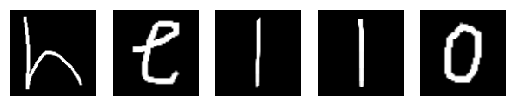

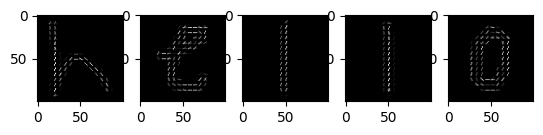

In [ ]:
# Display character images
print(f"Num characters: {len(userChars)}")
if len(userChars) == 1:
  plt.imshow(userChars[0], cmap=plt.cm.gray_r, interpolation="nearest")
else:
  fig, axes = plt.subplots(nrows=1, ncols=len(userChars))
  for ax, charImg in zip(axes, userChars):
    ax.set_axis_off()
    ax.imshow(charImg, cmap=plt.cm.gray_r, interpolation="nearest")

if len(hogImgs) == 1:
  plt.imshow(hogImgs[0], cmap="gray")
else:
  f, axes = plt.subplots(nrows=1, ncols=len(hogImgs))
  for ax, hogImg in zip(axes, hogImgs):
    ax.imshow(hogImg, cmap="gray")